In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, fbeta_score, classification_report, ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, det_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

In [11]:
full_data = pd.read_csv("../data/processed/full_all_day_ahead.csv")
# full_data.head()

cols_full = [c for c in full_data.columns if c == "Abnormal" or "_" in c]
data_full = full_data[cols_full]

# data_full[data_full.isna().any(axis=1)]
data_full = data_full.dropna()

X = data_full.drop(columns="Abnormal")
y = data_full["Abnormal"]

# for c in X.columns:
#   if X[c].min() == X[c].max():
#     print(c)

# RR cols appears to always have same value
X = X.drop(columns=["RR_1", "RR_2", "RR_3", "RR_4", "RR_5", "RR_6"])

y_bin = LabelEncoder().fit_transform(y)

# Test-train split
np.random.seed(7406)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size=0.7, stratify=y_bin)

In [16]:
smote = SMOTE(k_neighbors=10)
X_rs, y_rs = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
pca = PCA()
pca.fit(scaler.fit_transform(X_rs))
pca.explained_variance_ratio_.cumsum()

array([0.36683585, 0.61373078, 0.73133941, 0.79141179, 0.84089691,
       0.88463527, 0.91607848, 0.93861877, 0.95361222, 0.96014292,
       0.9660917 , 0.97050836, 0.97463174, 0.97748745, 0.97997643,
       0.98223816, 0.98424763, 0.98607204, 0.98762624, 0.98909235,
       0.99039447, 0.99163973, 0.99270835, 0.99366745, 0.99439633,
       0.99503023, 0.995532  , 0.99601486, 0.99640682, 0.99671919,
       0.99700786, 0.99729129, 0.99755363, 0.99780058, 0.99801574,
       0.99821296, 0.99839456, 0.99856551, 0.99871006, 0.99883358,
       0.99894449, 0.99904244, 0.99913417, 0.99921703, 0.99929258,
       0.99936602, 0.99943066, 0.99949363, 0.99954869, 0.9995985 ,
       0.99964576, 0.99969065, 0.99973268, 0.99976909, 0.99980202,
       0.99982912, 0.99985545, 0.99988093, 0.99990493, 0.99992604,
       0.99994539, 0.99995695, 0.99996772, 0.99997819, 0.99998685,
       0.99999346, 0.99999662, 0.99999811, 0.99999951, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [34]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
scaler = StandardScaler()

pipeline = Pipeline([("scaler", scaler),
                     ("pca", PCA(n_components=9)),
                     ("lr", LogisticRegression(n_jobs=-1, solver="saga", penalty="elasticnet"))])

param_grid = {
  "lr__C": [0.0001, 0.01, 0.1, 1, 10, 100, 1000],
  "lr__fit_intercept": [True, False],
  "lr__l1_ratio": [0, 0.0001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(fbeta_score, beta=2), cv=kf, refit=True)
grid_search.fit(X_rs, y_rs)
print(grid_search.best_params_)
print(grid_search.best_estimator_.named_steps["lr"].coef_)

{'lr__C': 1, 'lr__fit_intercept': False, 'lr__l1_ratio': 1}
[[-0.1256917   0.03751515  0.46258203 -0.3958441  -0.33427096 -0.11173166
  -0.07455854 -0.18971485 -0.37100749]]


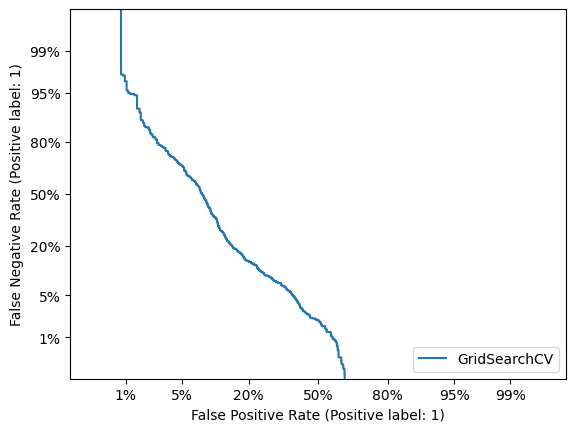

In [35]:
DetCurveDisplay.from_estimator(grid_search, X_rs, y_rs)

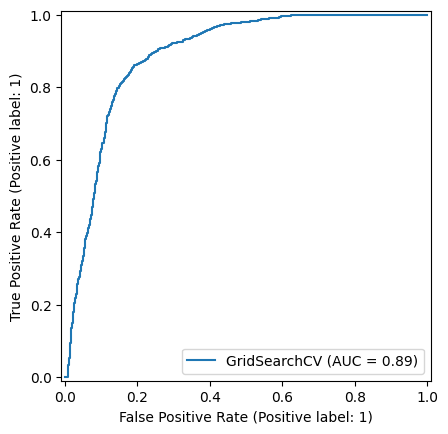

In [36]:
RocCurveDisplay.from_estimator(grid_search, X_rs, y_rs)

In [37]:
y_train_proba = grid_search.predict_proba(X_rs)[:,1]
fpr1, fnr, det_ts = det_curve(y_rs, y_train_proba)
fpr2, tpr, roc_ts = roc_curve(y_rs, y_train_proba)

sens = 1-fnr
spec = 1-fpr1


print("DET optimal threshold = ",det_ts[np.argmax(sens+spec)])
print("ROC optimal threshold =", roc_ts[np.argmax(tpr-fpr2)])


DET optimal threshold =  0.6012626941877576
ROC optimal threshold = 0.6012626941877576


0.8488437676254935
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1757
           1       0.82      0.86      0.84      1757

    accuracy                           0.83      3514
   macro avg       0.83      0.83      0.83      3514
weighted avg       0.83      0.83      0.83      3514



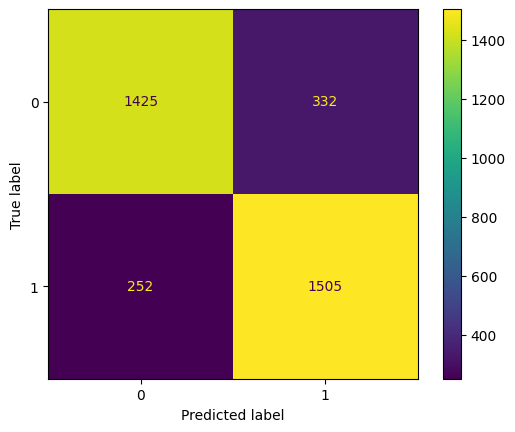

In [38]:
y_train_pred = [0 if p < 0.6 else 1 for p in y_train_proba]
y_test_pred = [0 if p < 0.6 else 1 for p in grid_search.predict_proba(X_test)[:,1]]

print(fbeta_score(y_rs, y_train_pred, beta=2))
print(classification_report(y_rs, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_rs, y_train_pred)

0.10810810810810811
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       753
           1       0.03      0.36      0.05        11

    accuracy                           0.81       764
   macro avg       0.51      0.59      0.47       764
weighted avg       0.97      0.81      0.88       764



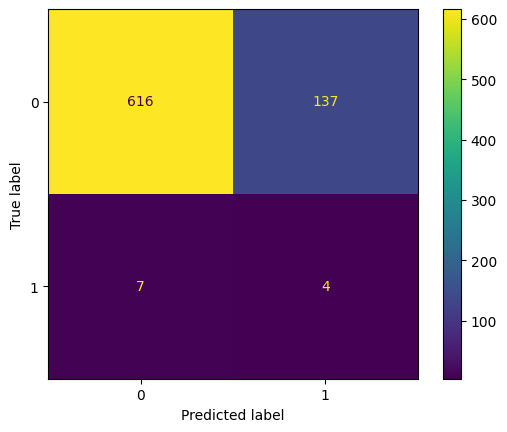

In [39]:
print(fbeta_score(y_test, y_test_pred, beta=2))
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)